# KLASIFIKASI CITRA MAGNETIC RESONANCE IMAGING (MRI) OTAK DALAM MENGIDENTIFIKASI TUMOR MENGGUNAKAN ALGORITMA RANDOM FOREST

## A. Tahapan Feature Extraction

### 1) Local Binary Pattern (LBP)

Tahapan awal sebelum melakukan klasifikasi pada citra otak manusia adalah tahapan ekstraksi fitur. Tahapan ini dilakukan untuk memperjelas tekstur pada citra

#### Import Library

In [1]:
#import Library
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.transform import resize
from skimage import feature 
from skimage.feature import greycomatrix, greycoprops
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

dibawah ini merupakan kode untuk mencari nilai pusat berdasarkan nilai disekelilingnya

In [2]:
def get_pixel(img, center, x, y): 
    new_value = 0 
    try: 
        #jika nilai ketetanggan lebih besar dari nilai pusat, maka set dengan nilai 1
        if img[x][y] >= center: 
            new_value = 1        
    except: 
        pass     
    return new_value 
   
# Function for calculating LBP 
def lbp_calculated_pixel(img, x, y): 
   
    center = img[x][y] 
   
    val_array = [] 
      
    # kiri atas
    val_array.append(get_pixel(img, center, x-1, y-1)) 
     
    # atas 
    val_array.append(get_pixel(img, center, x-1, y)) 
      
    # kanan atas 
    val_array.append(get_pixel(img, center, x-1, y + 1)) 
      
    # kanan
    val_array.append(get_pixel(img, center, x, y + 1)) 
      
    # kanan bawah 
    val_array.append(get_pixel(img, center, x + 1, y + 1)) 
      
    # bawah
    val_array.append(get_pixel(img, center, x + 1, y)) 
      
    # kiri bawah
    val_array.append(get_pixel(img, center, x + 1, y-1)) 
      
    # kiri
    val_array.append(get_pixel(img, center, x, y-1)) 
       
    # Now, we need to convert binary 
    # values to decimal 
    power_value = [1, 2, 4, 8, 16, 32, 64, 128] 
   
    val = 0
      
    for i in range(len(val_array)): 
        val += val_array[i] * power_value[i] 
          
    return val

Mengetahui ekstensi citra pada masing-masing folder (tumor dan non-tumor)

In [3]:
# determine extension of images
## brain tumor positive images
path = 'brain_tumor_dataset/brain_mri/yes'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'positive image extensions: {ext_set}')


## brain tumor negative images
path = 'brain_tumor_dataset/brain_mri/no'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'negative image extensions: {ext_set}')

positive image extensions: {'.jpg'}
negative image extensions: {'.jpg'}


Hitung banyaknya jumlah citra dari masing-masing folder

In [4]:
## positive
path = 'brain_tumor_dataset/brain_mri/yes'
pos_li = list(Path(path).glob('*.jpg'))


## negative
path = 'brain_tumor_dataset/brain_mri/no'
neg_li = list(Path(path).glob('*.jpg'))


# display number of images
print(f'Brain Tumor Positive images: {len(pos_li)}\nBrain Tumor Negative images: {len(neg_li)}')

Brain Tumor Positive images: 555
Brain Tumor Negative images: 335


Resize ukuran citra menjadi 300 x 300 pixel

In [5]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 300
pos_data = np.empty((len(pos_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
neg_data = np.empty((len(neg_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ float data type must be used to save precise pixel values

Konversi citra menjadi bentuk array

In [6]:
# convert images to numpy arrays
## positive
for i, img_path in enumerate(sorted(pos_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    pos_data[i] = img
## negative
for i, img_path in enumerate(sorted(neg_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    neg_data[i] = img

In [7]:
# scale image arrays
pos_data /= 255
neg_data /= 255

Buat folder/direktori baru untuk menyimpan hasil dari citra grayscale yang telah di ekstraksi dengan LBP

In [8]:
#make directory for LBP image
lbp = ['LBP_yes', 'LBP_no']
try:
    os.mkdir('brain_tumor_dataset/preprocess')
    os.mkdir('brain_tumor_dataset/preprocess/data_LBP/')
    for x in lbp:
      os.mkdir('brain_tumor_dataset/preprocess/data_LBP/'+x)
except OSError:
    # pass
    print('not run')

Simpan hasil ekstraksi LBP kedalam masing-masing folder

In [9]:
# LBP Positif
for i, img_path in enumerate(sorted(pos_li)):
    height, width, _ = pos_data[i].shape
    # Create a numpy array as  
    # the same height and width  
    # of RGB image 
    img_lbp = np.zeros((height, width), 
                       np.uint8) 
    
    for j in range(0, height): 
        for k in range(0, width): 
            img_lbp[j, k] = lbp_calculated_pixel(pos_data[i], j, k)
    
    newPath = str(pos_li[i]).split('\\')
    fileLoc = "brain_tumor_dataset/preprocess/data_LBP/LBP_yes/"+newPath[3]
    cv2.imwrite(fileLoc, img_lbp)

In [10]:
# LBP Negatif
for i, img_path in enumerate(sorted(neg_li)):
    height, width, _ = neg_data[i].shape
    # Create a numpy array as  
    # the same height and width  
    # of RGB image 
    img_lbp = np.zeros((height, width), 
                       np.uint8)
    
    for j in range(0, height): 
        for k in range(0, width): 
            img_lbp[j, k] = lbp_calculated_pixel(neg_data[i], j, k)
    
    newPath = str(neg_li[i]).split('\\')
    fileLoc = "brain_tumor_dataset/preprocess/data_LBP/LBP_no/"+newPath[3]
    cv2.imwrite(fileLoc, img_lbp)

Tampilan citra LBP

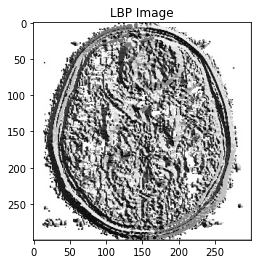

(300, 300, 3)


In [11]:
img = cv2.imread('brain_tumor_dataset/preprocess/data_LBP/LBP_yes/image(66).jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.title('LBP Image')
plt.show()
# print(img.shape)
print(img.shape)

### 2) Gray Level Co-occurence Matrix (GLCM)

Tahap kedua adalah ekstraksi fitur dengan menggunakan GLCM. Hasil dari ekstraksi ini adalah nilai fitur yang berdasarkan dari berbagai sudut, yakni 0˚, 45˚, 90˚, dan 135˚. Berikut tahapan GLCM pada kode dibawah ini.  

In [12]:
#Gray Level Co-occurence Matrix
# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
      
def label_nama(nama_label):
    if nama_label == 'LBP_yes':
        return 1
    else:
        return 0

# -------------------- Load Dataset ------------------------
 
dataset_dir ="brain_tumor_dataset/preprocess/"

imgs = [] #list image matrix 
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))           
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            imgs.append(gray)
#             labels.append(normalize_label(os.path.splitext(filename)[0]))
            nama_label = os.path.splitext(sub_folder)[0]
            labels.append(label_nama(nama_label))
            descs.append(normalize_desc(folder, sub_folder))
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)


[##########] folder : data_LBP/LBP_no/ ----> file : image.jpg.jpgg


In [13]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Lakukan perhitungan dengan GLCM dengan menggunakan 4 fitur, yakni contrast, correlation, ASM, dan homogeneity dari sudut 0, 45, 90, dan 135

In [14]:
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
# properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
properties = ['contrast','correlation', 'ASM', 'homogeneity']
glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

Buat DataFrame untuk menyimpan nilai fitur dari hasil perhitungan menggunakan GLCM

In [15]:
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

#save to csv
glcm_df.to_csv("glcm_brain_tumor.csv", index=False)

glcm_df

contrast_0   contrast_45   contrast_90  contrast_135  correlation_0  \
0     7050.585175   7213.745777   6618.020475   7452.814988       0.531943   
1    12783.909209  12502.021891  11675.925277  13171.959300       0.266928   
2     8273.799345   8342.216536   8040.462102   8909.977949       0.491086   
3     7701.034983   7733.696608   7444.638011   8016.006939       0.503863   
4    11401.929469  10187.865127   9181.011107  12443.604467       0.310639   
..            ...           ...           ...           ...            ...   
885  12868.579040  11768.337461  11599.587729  12935.890100       0.249216   
886  13685.982904  12344.087279  12539.759006  14481.667310       0.155731   
887  10632.726090  10308.455762   9603.042192  11223.883720       0.385895   
888  10241.758418   9870.708101   9414.919492  10762.868346       0.399474   
889  14920.222113  14499.305857  14286.036305  15589.515876       0.036411   

     correlation_45  correlation_90  correlation_135     ASM_0    ASM_45  \
0          0.522253        0.558608         0.506418  0.248011  0.244061   
1          0.283589        0.331790         0.245142  0.021851  0.020762   
2          0.489384        0.505401         0.454631  0.174617  0.168504   
3          0.504421        0.520243         0.486328  0.220397  0.212881   
4          0.386448        0.449038         0.250612  0.019143  0.018388   
..              ...             ...              ...       ...       ...   
885        0.312962        0.324167         0.244797  0.021212  0.018812   
886        0.237545        0.226511         0.105511  0.005411  0.003914   
887        0.406782        0.445541         0.354101  0.106945  0.100940   
888        0.422597        0.448242         0.370407  0.074047  0.069791   
889        0.063704        0.078185        -0.006669  0.000088  0.000086   

       ASM_90   ASM_135  homogeneity_0  homogeneity_45  homogeneity_90  \
0    0.252982  0.243665       0.523693        0.516824        0.533031   
1    0.024232  0.020709       0.181596        0.177430        0.197428   
2    0.175634  0.168113       0.448078        0.436015        0.451777   
3    0.220780  0.213062       0.496141        0.484588        0.497595   
4    0.021907  0.018430       0.198966        0.185534        0.207538   
..        ...       ...            ...             ...             ...   
885  0.021408  0.018844       0.181424        0.171467        0.187947   
886  0.004426  0.003920       0.120157        0.103664        0.112838   
887  0.107273  0.100879       0.357351        0.343401        0.361097   
888  0.075873  0.070196       0.311230        0.296891        0.319340   
889  0.000090  0.000085       0.036531        0.033707        0.039832   

     homogeneity_135  label  
0           0.516009      0  
1           0.175022      0  
2           0.435720      0  
3           0.484150      0  
4           0.183324      0  
..               ...    ...  
885         0.169761      1  
886         0.100768      1  
887         0.342154      1  
888         0.300479      1  
889         0.033263      1  

[890 rows x 17 columns]

## Lakukan Preprocessing pada Dataset Hasil GLCM

pisahkan kolom variabel dan kolom target

In [16]:
X = glcm_df.drop('label', axis=1)
y = glcm_df[['label']]

Hitung nilai rata-rata nilai fitur dari berbagai arah 

In [17]:
#calculate average of GLCM feature in each degree 
cor = ['correlation_0','correlation_45',
       'correlation_90','correlation_135']
homogen =['homogeneity_0','homogeneity_45',
          'homogeneity_90','homogeneity_135']
cont = ['contrast_0','contrast_45',
        'contrast_90','contrast_135']
ASM =  ['ASM_0','ASM_45','ASM_90','ASM_135']

X['correlation'] = X[cor].astype(float).mean(axis = 1)
X['homogeneity'] = X[homogen].astype(float).mean(axis=1)
X['contrast'] = X[cont].astype(float).mean(axis=1)
X['ASM'] = X[ASM].astype(float).mean(axis=1)

X

contrast_0   contrast_45   contrast_90  contrast_135  correlation_0  \
0     7050.585175   7213.745777   6618.020475   7452.814988       0.531943   
1    12783.909209  12502.021891  11675.925277  13171.959300       0.266928   
2     8273.799345   8342.216536   8040.462102   8909.977949       0.491086   
3     7701.034983   7733.696608   7444.638011   8016.006939       0.503863   
4    11401.929469  10187.865127   9181.011107  12443.604467       0.310639   
..            ...           ...           ...           ...            ...   
885  12868.579040  11768.337461  11599.587729  12935.890100       0.249216   
886  13685.982904  12344.087279  12539.759006  14481.667310       0.155731   
887  10632.726090  10308.455762   9603.042192  11223.883720       0.385895   
888  10241.758418   9870.708101   9414.919492  10762.868346       0.399474   
889  14920.222113  14499.305857  14286.036305  15589.515876       0.036411   

     correlation_45  correlation_90  correlation_135     ASM_0    ASM_45  \
0          0.522253        0.558608         0.506418  0.248011  0.244061   
1          0.283589        0.331790         0.245142  0.021851  0.020762   
2          0.489384        0.505401         0.454631  0.174617  0.168504   
3          0.504421        0.520243         0.486328  0.220397  0.212881   
4          0.386448        0.449038         0.250612  0.019143  0.018388   
..              ...             ...              ...       ...       ...   
885        0.312962        0.324167         0.244797  0.021212  0.018812   
886        0.237545        0.226511         0.105511  0.005411  0.003914   
887        0.406782        0.445541         0.354101  0.106945  0.100940   
888        0.422597        0.448242         0.370407  0.074047  0.069791   
889        0.063704        0.078185        -0.006669  0.000088  0.000086   

       ASM_90   ASM_135  homogeneity_0  homogeneity_45  homogeneity_90  \
0    0.252982  0.243665       0.523693        0.516824        0.533031   
1    0.024232  0.020709       0.181596        0.177430        0.197428   
2    0.175634  0.168113       0.448078        0.436015        0.451777   
3    0.220780  0.213062       0.496141        0.484588        0.497595   
4    0.021907  0.018430       0.198966        0.185534        0.207538   
..        ...       ...            ...             ...             ...   
885  0.021408  0.018844       0.181424        0.171467        0.187947   
886  0.004426  0.003920       0.120157        0.103664        0.112838   
887  0.107273  0.100879       0.357351        0.343401        0.361097   
888  0.075873  0.070196       0.311230        0.296891        0.319340   
889  0.000090  0.000085       0.036531        0.033707        0.039832   

     homogeneity_135  correlation  homogeneity      contrast       ASM  
0           0.516009     0.529806     0.522389   7083.791604  0.247180  
1           0.175022     0.281862     0.182869  12533.453919  0.021889  
2           0.435720     0.485125     0.442897   8391.613983  0.171717  
3           0.484150     0.503714     0.490618   7723.844135  0.216780  
4           0.183324     0.349184     0.193840  10803.602543  0.019467  
..               ...          ...          ...           ...       ...  
885         0.169761     0.282786     0.177650  12293.098582  0.020069  
886         0.100768     0.181325     0.109357  13262.874124  0.004418  
887         0.342154     0.398080     0.351001  10442.026941  0.104009  
888         0.300479     0.410180     0.306985  10072.563589  0.072477  
889         0.033263     0.042908     0.035833  14823.770038  0.000087  

[890 rows x 20 columns]

In [18]:
dfx = X.iloc[:, 16:]
df = pd.DataFrame(dfx)
df

correlation  homogeneity      contrast       ASM
0       0.529806     0.522389   7083.791604  0.247180
1       0.281862     0.182869  12533.453919  0.021889
2       0.485125     0.442897   8391.613983  0.171717
3       0.503714     0.490618   7723.844135  0.216780
4       0.349184     0.193840  10803.602543  0.019467
..           ...          ...           ...       ...
885     0.282786     0.177650  12293.098582  0.020069
886     0.181325     0.109357  13262.874124  0.004418
887     0.398080     0.351001  10442.026941  0.104009
888     0.410180     0.306985  10072.563589  0.072477
889     0.042908     0.035833  14823.770038  0.000087

[890 rows x 4 columns]

In [19]:
df['label']=y
df

correlation  homogeneity      contrast       ASM  label
0       0.529806     0.522389   7083.791604  0.247180      0
1       0.281862     0.182869  12533.453919  0.021889      0
2       0.485125     0.442897   8391.613983  0.171717      0
3       0.503714     0.490618   7723.844135  0.216780      0
4       0.349184     0.193840  10803.602543  0.019467      0
..           ...          ...           ...       ...    ...
885     0.282786     0.177650  12293.098582  0.020069      1
886     0.181325     0.109357  13262.874124  0.004418      1
887     0.398080     0.351001  10442.026941  0.104009      1
888     0.410180     0.306985  10072.563589  0.072477      1
889     0.042908     0.035833  14823.770038  0.000087      1

[890 rows x 5 columns]

simpan hasil nilai rata-rata tiap fitur kedalam file CSV

In [20]:
df.to_csv("dataset_mri.csv", index=False)

## B. Tahapan Klasifikasi dengan Random Forest

Import file CSV hasil fitur yang telah didapatkan dari GLCM

In [21]:
df = pd.read_csv('dataset_mri.csv')
df = pd.DataFrame(df)
df

correlation  homogeneity      contrast       ASM  label
0       0.529806     0.522389   7083.791604  0.247180      0
1       0.281862     0.182869  12533.453919  0.021889      0
2       0.485125     0.442897   8391.613983  0.171717      0
3       0.503714     0.490618   7723.844135  0.216780      0
4       0.349184     0.193840  10803.602543  0.019467      0
..           ...          ...           ...       ...    ...
885     0.282786     0.177650  12293.098582  0.020069      1
886     0.181325     0.109357  13262.874124  0.004418      1
887     0.398080     0.351001  10442.026941  0.104009      1
888     0.410180     0.306985  10072.563589  0.072477      1
889     0.042908     0.035833  14823.770038  0.000087      1

[890 rows x 5 columns]

kemudian, pisahkan kolom variabel dan kolom target

In [22]:
#split dataset to X(data) and y(label)
X = df.drop('label', axis=1)
y = df[['label']]

Split dataset menjadi data training dan data testing dengan rasio yang telah ditentukan

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Lihat jumlah persebaran data training dan data testing

In [24]:
print('Jumlah Persebaran Data Training dan Testing Hasil Splitting')
print('=' * 20)
print('Jumlah Data Training: ' + str(X_train.shape))
print('Jumlah Data Testing: ' + str(X_test.shape))

Jumlah Persebaran Data Training dan Testing Hasil Splitting
Jumlah Data Training: (623, 4)
Jumlah Data Testing: (267, 4)


Pada tahapan ini, inisiasi terlebih dahulu parameter jumlah pohon (n_estimator) dan kedalaman pohon (max_depth)

In [25]:
#classification
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8)
model_rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=8, random_state=42)

In [26]:
rf_result = model_rf.predict(X_test)
akurasi_rf = accuracy_score(y_test.values.ravel(), rf_result)*100
presisi_rf = precision_score(y_test.values.ravel(), rf_result)*100
recall_rf = recall_score(y_test.values.ravel(), rf_result)*100
print('Akurasi = {:.2f} Presisi = {:.2f} Recall = {:.2f}'. format(akurasi_rf, presisi_rf, recall_rf))

Akurasi = 87.64 Presisi = 90.53 Recall = 90.00


Setelah melakukan inisialisasi parameter dan training dengan Random Forest, selanjutnya visualisasikan salah satu tree (pohon) dari "n" pohon pada Random Forest

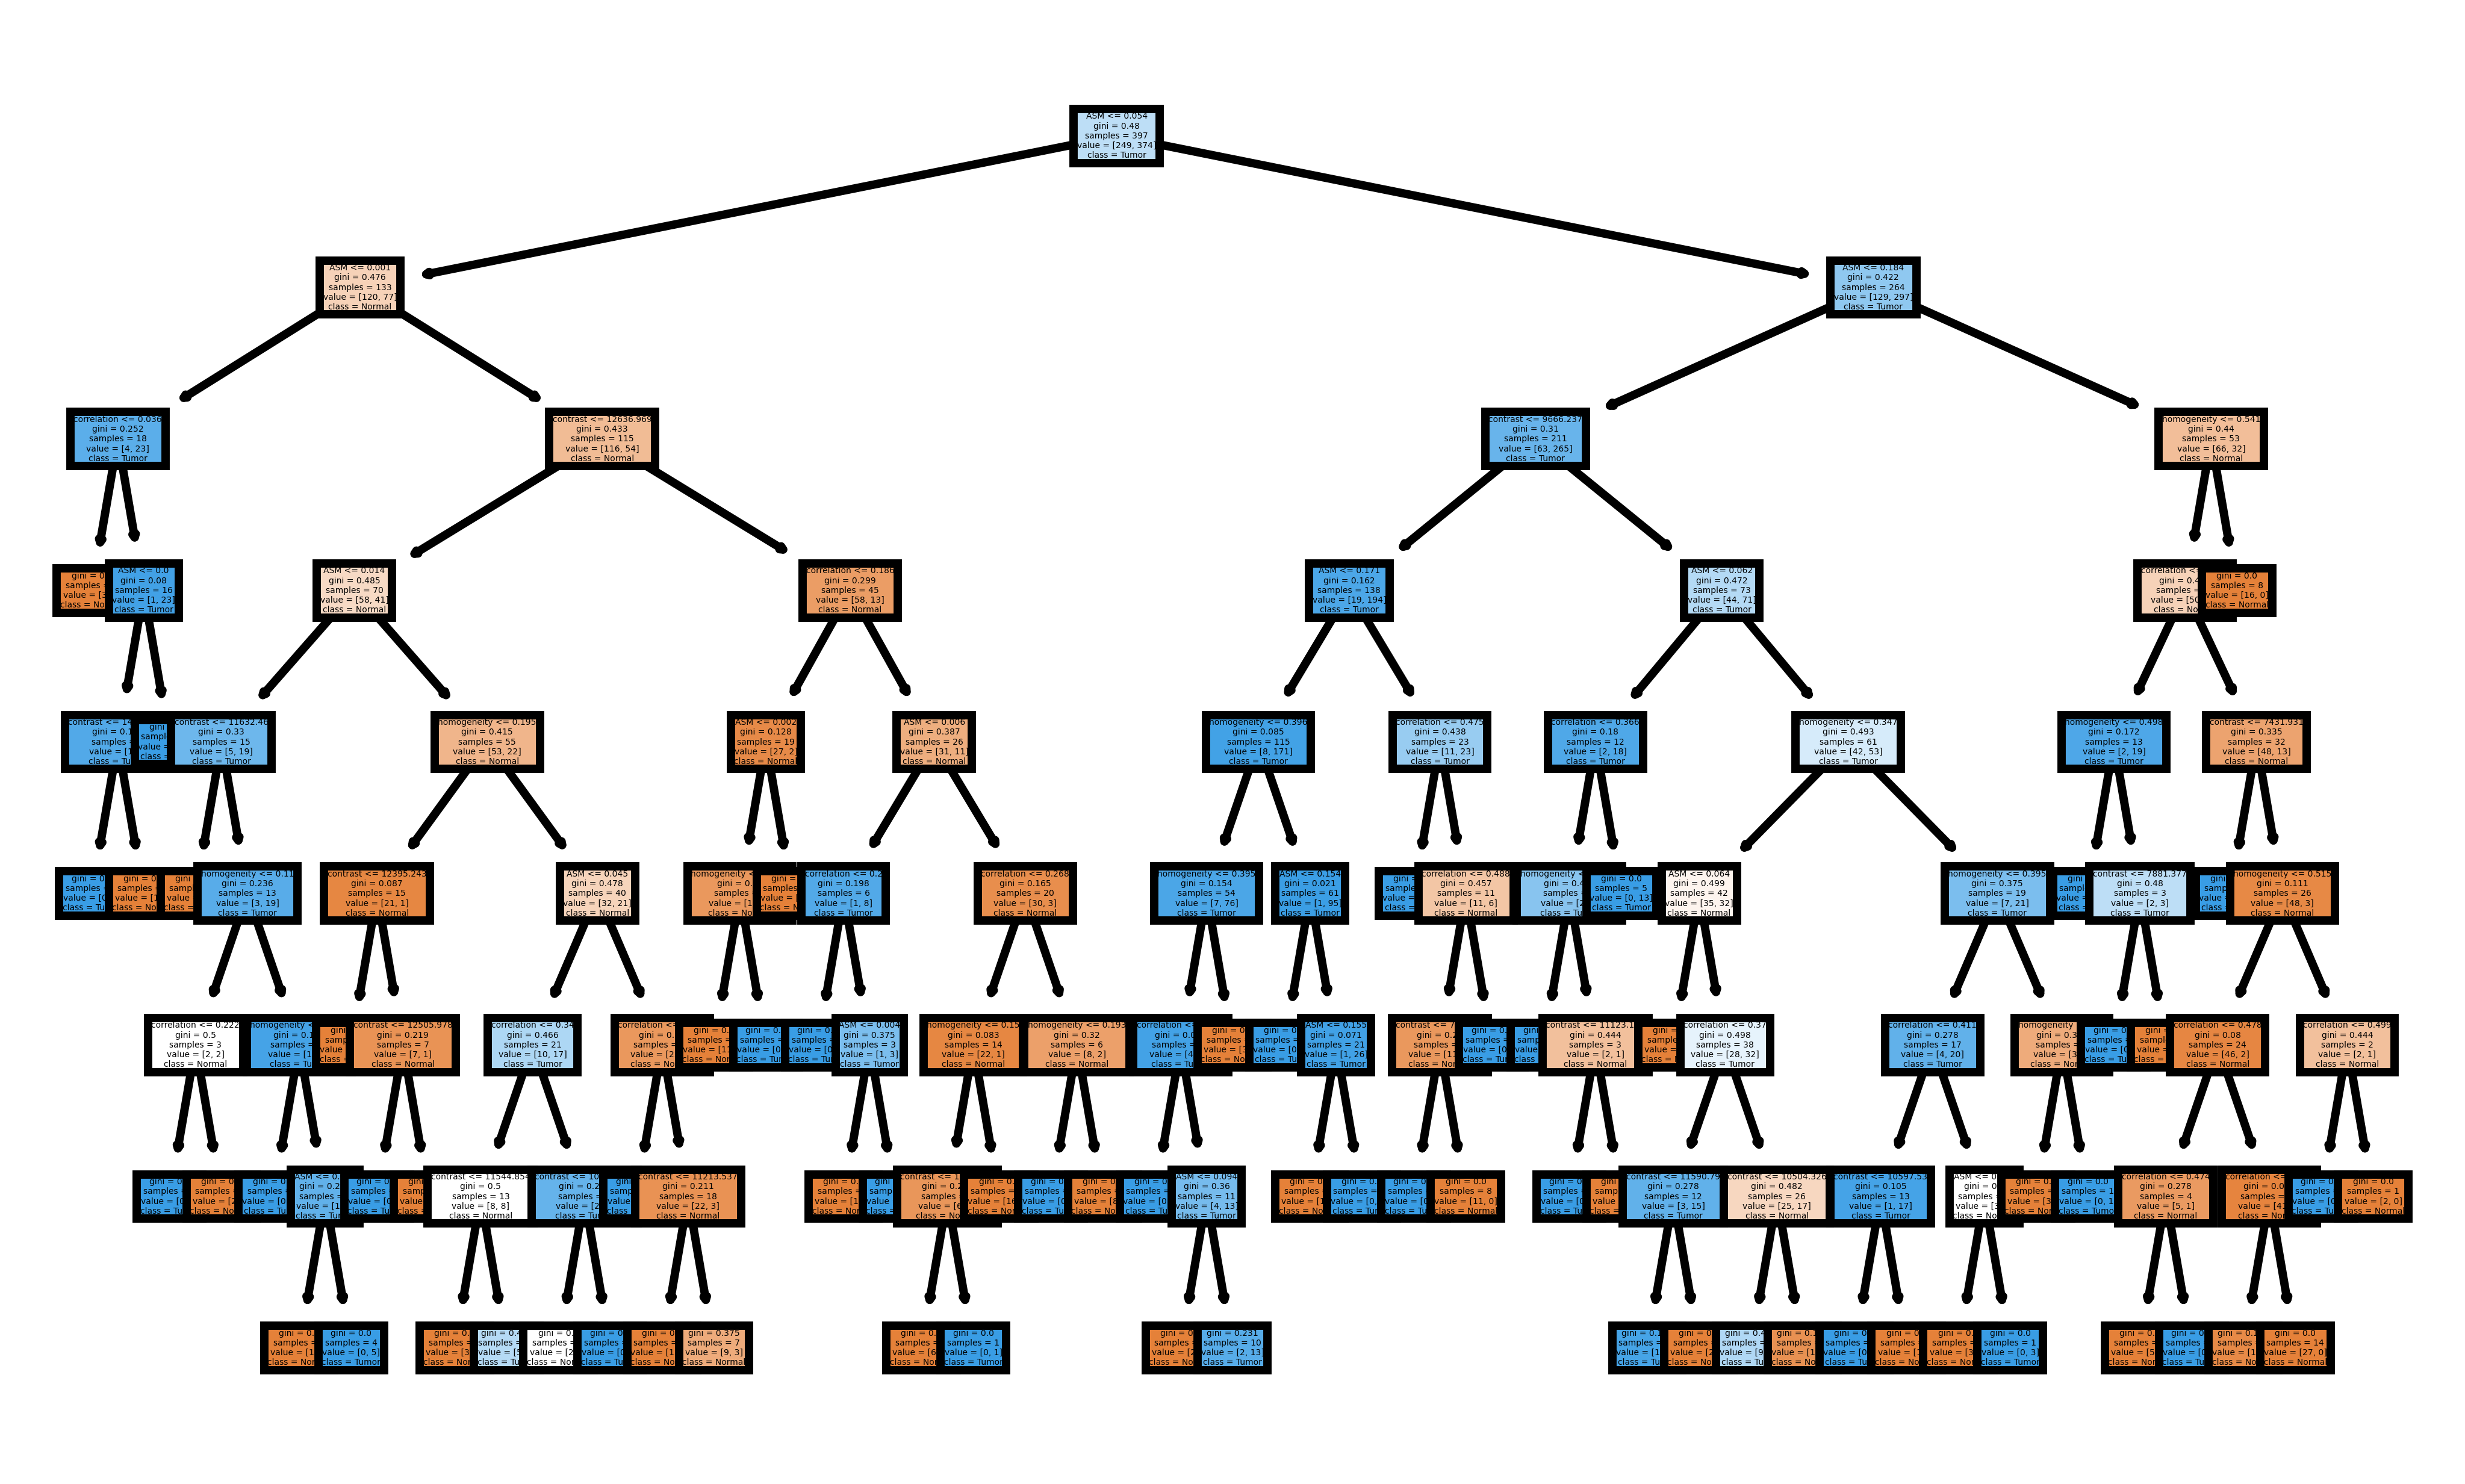

In [27]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,3), dpi=1000)
tree.plot_tree(model_rf.estimators_[0], 
          class_names=['Normal', 'Tumor'], 
          filled = True, 
          feature_names=X_train.columns);
# fig.savefig('rf_individualtree.png')

Visualisasi tree dalam bentuk text

keterangan : feature_0 = correlation, feature_1 = homogeneity, feature_2 = contrast, feature_3 = IDM

class ==> 0 : Normal, 1 : Tumor

In [28]:
for i in range(len(model_rf.estimators_)):
  print(tree.export_text(model_rf.estimators_[i]))

|--- feature_3 <= 0.05
|   |--- feature_3 <= 0.00
|   |   |--- feature_0 <= 0.04
|   |   |   |--- class: 0.0
|   |   |--- feature_0 >  0.04
|   |   |   |--- feature_3 <= 0.00
|   |   |   |   |--- feature_2 <= 14925.44
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- feature_2 >  14925.44
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- feature_3 >  0.00
|   |   |   |   |--- class: 1.0
|   |--- feature_3 >  0.00
|   |   |--- feature_2 <= 12636.97
|   |   |   |--- feature_3 <= 0.01
|   |   |   |   |--- feature_2 <= 11632.46
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_2 >  11632.46
|   |   |   |   |   |--- feature_1 <= 0.11
|   |   |   |   |   |   |--- feature_0 <= 0.22
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- feature_0 >  0.22
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_1 >  0.11
|   |   |   |   |   |   |--- feature_1 <= 0.15
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   | 


|--- feature_1 <= 0.35
|   |--- feature_3 <= 0.00
|   |   |--- feature_0 <= 0.05
|   |   |   |--- feature_3 <= 0.00
|   |   |   |   |--- class: 1.0
|   |   |   |--- feature_3 >  0.00
|   |   |   |   |--- class: 0.0
|   |   |--- feature_0 >  0.05
|   |   |   |--- class: 1.0
|   |--- feature_3 >  0.00
|   |   |--- feature_2 <= 9665.38
|   |   |   |--- feature_2 <= 9506.69
|   |   |   |   |--- class: 0.0
|   |   |   |--- feature_2 >  9506.69
|   |   |   |   |--- feature_1 <= 0.28
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_1 >  0.28
|   |   |   |   |   |--- class: 1.0
|   |   |--- feature_2 >  9665.38
|   |   |   |--- feature_2 <= 9971.40
|   |   |   |   |--- feature_2 <= 9715.24
|   |   |   |   |   |--- feature_0 <= 0.39
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_0 >  0.39
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- feature_2 >  9715.24
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- feature_2 >  9971.40
|   |   | 

Berikut contoh visualisasi Random Forest dengan 4 pohon

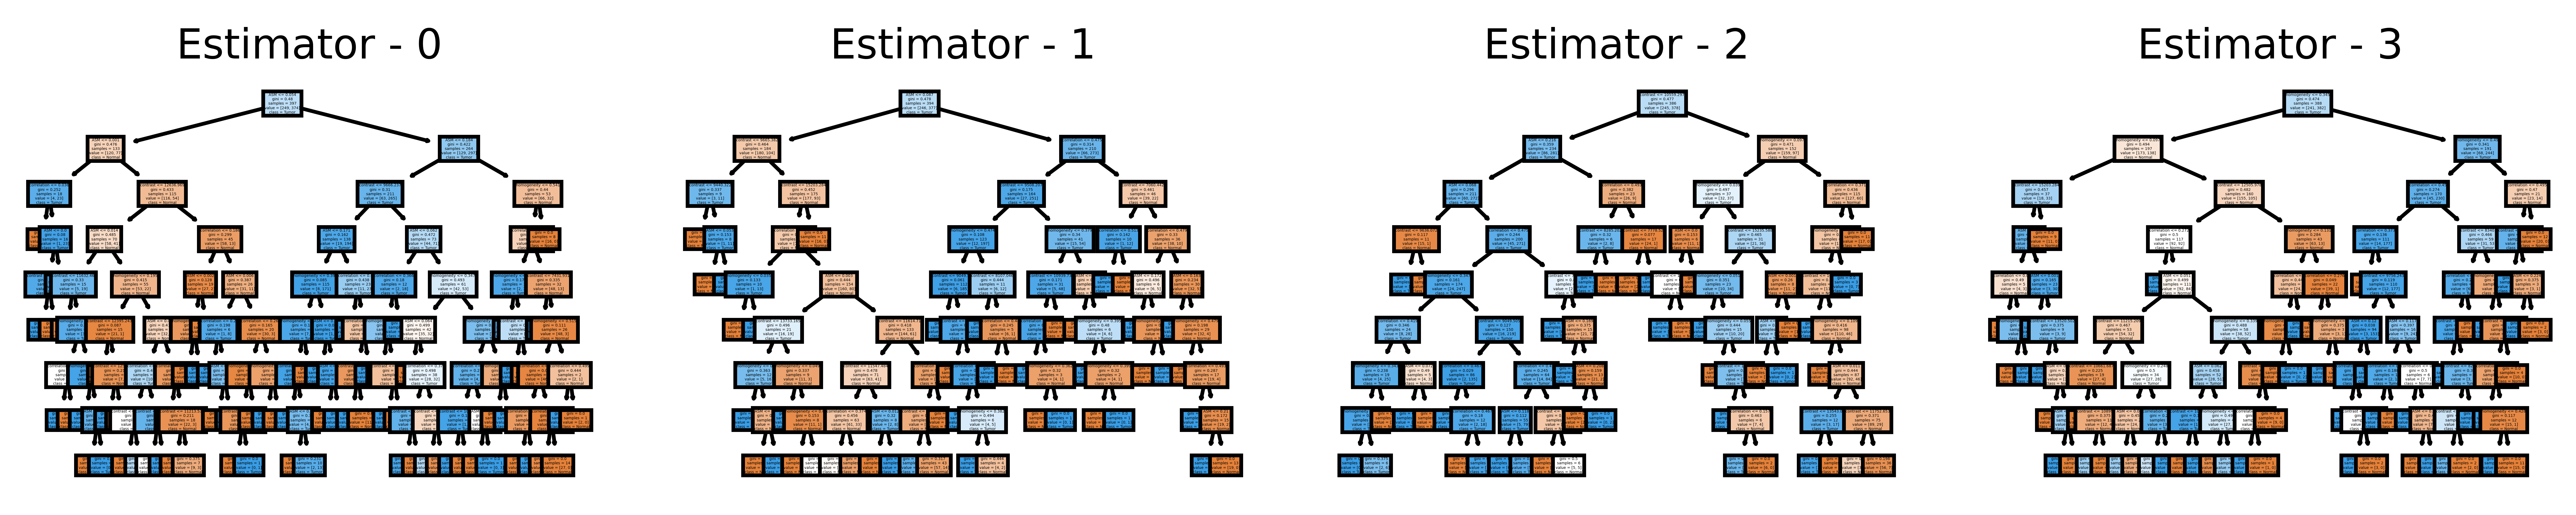

In [29]:
fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (12,2), dpi=1000)

for x in range (0,4):
    tree.plot_tree(model_rf.estimators_[x], 
          class_names=['Normal', 'Tumor'], 
          filled = True, 
          feature_names=X_train.columns,
          ax = axes[x]);
    axes[x].set_title('Estimator - ' + str(x), fontsize = 11)

## C. Evaluasi Model

### Confusion Matrix

In [30]:
print('Test Loop Accuracy in Forest = ') 
print('---------------------------------------') 
for i in range(1,16): 
    model_rf = RandomForestClassifier(n_estimators=i, random_state = 42) 
    model_rf.fit(X_train, y_train.values.ravel()) 
    print(" - > TEST set score : " +str(i)+" estimators:{:.5}".format(model_rf.score(X_test, y_test))) 
print('---------------------------------------')

Test Loop Accuracy in Forest = 
---------------------------------------
 - > TEST set score : 1 estimators:0.81273
 - > TEST set score : 2 estimators:0.80524
 - > TEST set score : 3 estimators:0.84644
 - > TEST set score : 4 estimators:0.81648
 - > TEST set score : 5 estimators:0.86891
 - > TEST set score : 6 estimators:0.86142
 - > TEST set score : 7 estimators:0.88764
 - > TEST set score : 8 estimators:0.8764
 - > TEST set score : 9 estimators:0.88764
 - > TEST set score : 10 estimators:0.88015
 - > TEST set score : 11 estimators:0.88015
 - > TEST set score : 12 estimators:0.88015
 - > TEST set score : 13 estimators:0.88764
 - > TEST set score : 14 estimators:0.8839
 - > TEST set score : 15 estimators:0.8839
---------------------------------------


Precision, Recall, dan Accuracy

In [31]:
print("=== Confusion Matrix ===")
cf_matrix = confusion_matrix(y_test, rf_result, labels=[1,0])
print(cf_matrix)
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rf_result))

=== Confusion Matrix ===
[[153  17]
 [ 16  81]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        97
           1       0.91      0.90      0.90       170

    accuracy                           0.88       267
   macro avg       0.87      0.87      0.87       267
weighted avg       0.88      0.88      0.88       267



Plot Confusion Matrix

<AxesSubplot:>

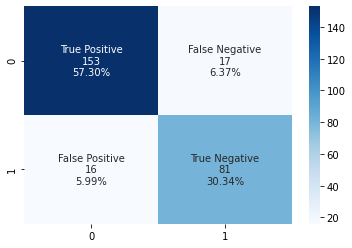

In [32]:
#plot confusion matrix

group_names = ['True Positive','False Negative','False Positive','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')